In [1]:
import sys
import gym
import pylab
import random
import numpy as np
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential

EPISODES = 300

Using TensorFlow backend.


In [2]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.render = False
        self.load_model = False

        # 상태와 행동의 크기 정의
        self.state_size = state_size
        self.action_size = action_size

        # DQN 하이퍼파라미터
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.batch_size = 64
        self.train_start = 1000

        # 리플레이 메모리, 최대 크기 2000
        self.memory = deque(maxlen=2000)

        # 모델과 타깃 모델 생성
        self.model = self.build_model()
        self.target_model = self.build_model()

        # 타깃 모델 초기화
        self.update_target_model()

        if self.load_model:
            self.model.load_weights("./save_model/cartpole_dqn_trained.h5")

    # 상태가 입력, 큐함수가 출력인 인공신경망 생성
    def build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(24, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear',
                        kernel_initializer='he_uniform'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    # 타깃 모델을 모델의 가중치로 업데이트
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # 입실론 탐욕 정책으로 행동 선택
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])

    # 샘플 <s, a, r, s'>을 리플레이 메모리에 저장
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # 리플레이 메모리에서 무작위로 추출한 배치로 모델 학습
    def train_model(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # 메모리에서 배치 크기만큼 무작위로 샘플 추출
        mini_batch = random.sample(self.memory, self.batch_size)

        states = np.zeros((self.batch_size, self.state_size))
        next_states = np.zeros((self.batch_size, self.state_size))
        actions, rewards, dones = [], [], []

        for i in range(self.batch_size):
            states[i] = mini_batch[i][0]
            actions.append(mini_batch[i][1])
            rewards.append(mini_batch[i][2])
            next_states[i] = mini_batch[i][3]
            dones.append(mini_batch[i][4])

        # 현재 상태에 대한 모델의 큐함수
        # 다음 상태에 대한 타깃 모델의 큐함수
        target = self.model.predict(states)
        target_val = self.target_model.predict(next_states)

        # 벨만 최적 방정식을 이용한 업데이트 타깃
        for i in range(self.batch_size):
            if dones[i]:
                target[i][actions[i]] = rewards[i]
            else:
                target[i][actions[i]] = rewards[i] + self.discount_factor * (
                    np.amax(target_val[i]))

        self.model.fit(states, target, batch_size=self.batch_size,
                       epochs=1, verbose=0)

In [3]:
# For Jupyter Notebook
import gym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt

KeyboardInterrupt: 

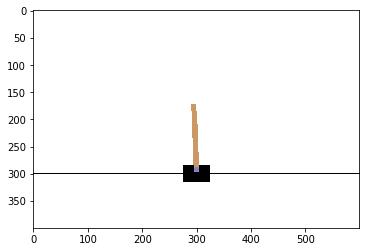

In [4]:
# CartPole-v1 환경, 최대 타임스텝 수가 500
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
# DQN 에이전트 생성
agent = DQNAgent(state_size, action_size)
scores, episodes = [], []

for e in range(EPISODES):
    done = False
    score = 0
    # env 초기화
    state = env.reset()
    # For Jupyter Notebook
    img = plt.imshow(env.render(mode='rgb_array')) # only call this once
    
    state = np.reshape(state, [1, state_size])

    while not done:
        if agent.render:
            env.render()
        # For Jupyter Notebook
        img.set_data(env.render(mode='rgb_array')) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        # 현재 상태로 행동을 선택
        action = agent.get_action(state)
        # 선택한 행동으로 환경에서 한 타임스텝 진행
        next_state, reward, done, info = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        # 에피소드가 중간에 끝나면 -100 보상
        reward = reward if not done or score == 499 else -100

        # 리플레이 메모리에 샘플 <s, a, r, s'> 저장
        agent.append_sample(state, action, reward, next_state, done)
        # 매 타임스텝마다 학습
        if len(agent.memory) >= agent.train_start:
            agent.train_model()

        score += reward
        state = next_state

        if done:
            # 각 에피소드마다 타깃 모델을 모델의 가중치로 업데이트
            agent.update_target_model()

            score = score if score == 500 else score + 100
            # 에피소드마다 학습 결과 출력
            scores.append(score)
            episodes.append(e)
            if e%20 == 0:
                pylab.plot(episodes, scores, 'b')
                pylab.savefig("./graph/cartpole_dqn_"+str(e)+".png")
            print("episode:", e, "  score:", score, "  memory length:",
                  len(agent.memory), "  epsilon:", agent.epsilon)

            # 이전 10개 에피소드의 점수 평균이 490보다 크면 학습 중단
            if np.mean(scores[-min(10, len(scores)):]) > 490:
                agent.model.save_weights("./model/cartpole_dqn_"+str(e)+".h5")
                sys.exit()